# Continuous Evaluation Exercises for Quantum Algorithms and Quantum Noise

#### Student: Fernando Soto

### Draw the Quantum Fourier Transform (QFT) circuit for 2 qubits

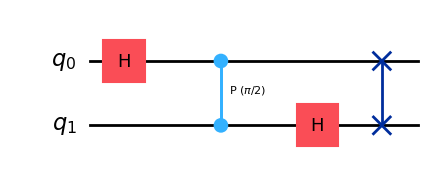

In [77]:
from qiskit import QuantumCircuit
import numpy as np

# 2-qubit circuit
qc = QuantumCircuit(2)

# Hadamard on q0
qc.h(0)

# Controlled phase rotation (R2)
qc.cp(np.pi/2, 1, 0)  # control=1, target=0

# Hadamard on q1
qc.h(1)

# Swap qubits
qc.swap(0, 1)

# Plot
qc.draw('mpl')


#### a) Check that it correctly reproduces the operation 

$$ U_{QFT}\ket{k}=\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}e^{2\pi i j k /N}\ket{j} $$


In [78]:
from qiskit.quantum_info import Operator, Statevector

def get_theoretical_qft_evolution(k,N):
    return np.array([np.exp(2j*np.pi*j*k/N)/np.sqrt(N) for j in range(N)])

def get_implemented_qft_evolution(qc, k,N):
    initial_state = Statevector.from_int(k,N)
    return initial_state.evolve(qc)


N=4
# In Qiskit, qubit 0 is the least significant bit in the statevector ordering
# That means the basis ordering is ∣00⟩,∣10⟩,∣01⟩,∣11⟩
# instead of the classic binary ordering ∣00⟩,∣01⟩,∣10⟩,∣11⟩
qiskit_order = [0,2,1,3] 
for k in range(N):
    theoretical = get_theoretical_qft_evolution(k,N)[qiskit_order]
    implemented = get_implemented_qft_evolution(qc,qiskit_order[k],N)
    print(f"k={k}")
    print(f"theoretical:{np.round(theoretical,1)}")
    print(f"implemented:{np.round(implemented,1)}")
    print(f"match:{np.round(implemented,1)==np.round(theoretical,1)}")


k=0
theoretical:[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
implemented:[0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
match:[ True  True  True  True]
k=1
theoretical:[ 0.5+0.j  -0.5+0.j   0. +0.5j -0. -0.5j]
implemented:[ 0.5+0.j  -0.5+0.j   0. +0.5j -0. -0.5j]
match:[ True  True  True  True]
k=2
theoretical:[ 0.5+0.j  0.5-0.j -0.5+0.j -0.5+0.j]
implemented:[ 0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]
match:[ True  True  True  True]
k=3
theoretical:[ 0.5+0.j  -0.5+0.j  -0. -0.5j  0. +0.5j]
implemented:[ 0.5+0.j  -0.5+0.j  -0. -0.5j  0. +0.5j]
match:[ True  True  True  True]


#### b) Obtain the matrix that represents the QFT in the computational basis. Is this matrix unitary?

In [79]:
# Get the unitary matrix
U_QFT = Operator(qc).data


print("\nUnitary matrix:\n")
print(np.round(U_QFT, 1))

# Check unitarity
identity = np.eye(U_QFT.shape[0])
check = np.allclose(U_QFT.conj().T @ U_QFT, identity)
print("\nIs U_QFT unitary?", check)


Unitary matrix:

[[ 0.5+0.j   0.5+0.j   0.5+0.j   0.5+0.j ]
 [ 0.5+0.j   0.5+0.j  -0.5+0.j  -0.5+0.j ]
 [ 0.5+0.j  -0.5+0.j   0. +0.5j -0. -0.5j]
 [ 0.5+0.j  -0.5+0.j  -0. -0.5j  0. +0.5j]]

Is U_QFT unitary? True


### 2. Consider a one-dimensional discrete-time quantum walk defined by the following map for 
### $$\psi_j(p) = \begin{pmatrix}\psi_j^{\uparrow}(p)\\ \psi_j^{\downarrow}(p) \end{pmatrix}$$
### $$ \psi_{j+1}^{\uparrow}(p) = \cos{\theta}\psi_{j}^{\uparrow}(p-1)+\sin{\theta}\psi_{j}^{\downarrow}(p+1)$$
### $$ \psi_{j+1}^{\downarrow}(p) = \sin{\theta}\psi_{j}^{\uparrow}(p-1)-\cos{\theta}\psi_{j}^{\downarrow}(p+1)$$
### where $j = 0, 1, ...$ represents the time step, and $p \in \mathbb{Z}$ indicates the position along the line, with $\theta = \pi/4$ (Hadamard walk). 
### The walker is initially placed at $p = 0$, such that $\psi_0^{\uparrow}(p)=\frac{1}{\sqrt{2}}\delta_{p,0}$, and $\psi_0^{\downarrow}(p)=\frac{i}{\sqrt{2}}\delta_{p,0}$ ($\delta_{p,q}$ stands for the Kroneckr delta function). 
### Use your favorite software (Mathematica, Python, ...) to obtain $\psi_j^{\uparrow}(p)$, $\psi_j^{\downarrow}(p)$ and the probability distribution $P_j(p)=|\psi_j^{\uparrow}(p)|²+|\psi_j^{\downarrow}(p)|²$ after two and three time steps (i.e. $j = 2$ and $j = 3$).
### It can also be done by hand. From your results, try to make an statement about the differences one should expect in the probability distribution when comparing an even or odd number of time steps.

--- Qiskit Simulation Setup ---
Total Qubits: 4 (1 coin + 3 position)


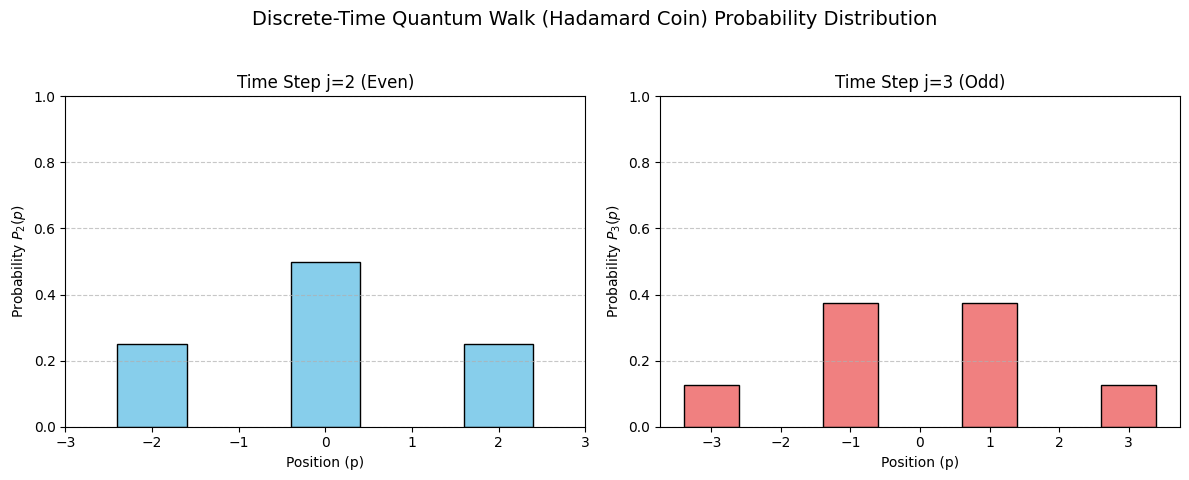


Verification (j=2): Total Probability = 1.000000
Verification (j=3): Total Probability = 1.000000


In [81]:
# --- Constants for Hadamard Walk (theta = pi/4) ---
THETA = np.pi / 4 # Define theta parameter explicitly
SQRT2 = np.sqrt(2)
COS_THETA = np.cos(THETA) # Use trigonometric functions of theta
SIN_THETA = np.sin(THETA) # Use trigonometric functions of theta

def shift_operator(num_pos_states, coin_size=2):
    r"""
    Constructs the Shift operator matrix S based on the map:
    S|up>|p> = |up>|p-1>
    S|down>|p> = |down>|p+1>
    
    The state space order is |coin> \otimes |position>.
    The shift uses modular arithmetic due to the finite register size N.
    """
    N = num_pos_states 
    TotalDim = coin_size * N
    S = np.zeros((TotalDim, TotalDim), dtype=complex)
    
    for c in range(coin_size): # c=0 for up (0), c=1 for down (1)
        for p in range(N):
            # Calculate the target position index (p') in the register
            if c == 0: # Up (Shift Left: p -> p-1 mod N)
                p_prime = (p - 1) % N
            else: # Down (Shift Right: p -> p+1 mod N)
                p_prime = (p + 1) % N
                
            # Current basis index: index = c * N + p
            current_index = c * N + p
            # Target basis index: target_index = c * N + p'
            target_index = c * N + p_prime
            
            # Place 1 in the matrix S[target_index, current_index]
            S[target_index, current_index] = 1.0
            
    return Operator(S)

def coin_operator(coin_size=2):
    """
    Constructs the Coin operator matrix C using the theta parameter.
    The map is defined by the unitary: 
    [[cos(theta), sin(theta)], [sin(theta), -cos(theta)]]
    """
    H = np.array([[COS_THETA, SIN_THETA], 
                  [SIN_THETA, -COS_THETA]], dtype=complex)
    return Operator(H)

def plot_distribution(results):
    """Generates and displays bar charts of the probability distribution."""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Discrete-Time Quantum Walk (Hadamard Coin) Probability Distribution', fontsize=14)

    # Time Step j=2 Plot
    res_j2 = results[2]
    positions_j2 = list(res_j2['probabilities'].keys())
    probs_j2 = list(res_j2['probabilities'].values())
    
    axes[0].bar(positions_j2, probs_j2, width=0.8, color='skyblue', edgecolor='black')
    axes[0].set_title(f'Time Step j=2 (Even)')
    axes[0].set_xlabel('Position (p)')
    axes[0].set_ylabel('Probability $P_2(p)$')
    axes[0].set_xticks(range(-3, 4)) # Set visible ticks for context
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[0].set_ylim(0, 1)

    # Time Step j=3 Plot
    res_j3 = results[3]
    positions_j3 = list(res_j3['probabilities'].keys())
    probs_j3 = list(res_j3['probabilities'].values())

    axes[1].bar(positions_j3, probs_j3, width=0.8, color='lightcoral', edgecolor='black')
    axes[1].set_title(f'Time Step j=3 (Odd)')
    axes[1].set_xlabel('Position (p)')
    axes[1].set_ylabel('Probability $P_3(p)$')
    axes[1].set_xticks(range(-3, 4)) # Set visible ticks for context
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def run_qiskit_simulation(target_steps=3):
    # --- Qubit Setup ---
    # Max position reached is +/- 3. We use 3 position qubits (N=8 states).
    num_pos_qubits = 3
    num_pos_states = 2**num_pos_qubits # N=8
    
    # Map from register state 'p' to physical position 'p_phys':
    # Initial state p=0 maps to register state |100> (index 4).
    offset = 4 
    
    # --- Step 1: Initialize the State Vector ---
    # Initial state: |psi_0> = (1/sqrt(2)|up> + i/sqrt(2)|down>) |p=0>
    
    # Position state: |p=0> corresponds to register index 'offset'
    initial_position_state = np.zeros(num_pos_states, dtype=complex)
    initial_position_state[offset] = 1.0 
    
    # Coin state: |psi_coin> = 1/sqrt(2) |0> + i/sqrt(2) |1>
    initial_coin_state = np.array([1 / SQRT2, 1j / SQRT2], dtype=complex)
    
    # Total initial state: |psi_0> = |psi_coin> \otimes |p=0>
    psi = Statevector(np.kron(initial_coin_state, initial_position_state))
    
    # --- Step 2: Define Operators ---
    # Total Unitary evolution operator for one step: U = S * (C \otimes I_P)
    
    # Coin operator C_total = C \otimes I_P
    C_op = coin_operator()
    C_total = C_op.tensor(Operator.from_label('I' * num_pos_qubits)) 
    
    # Shift operator S_op
    S_op = shift_operator(num_pos_states)
    
    # Total Unitary operator U (applied as S then C)
    U_op = S_op.compose(C_total)
    
    print(f"--- Qiskit Simulation Setup ---")
    print(f"Total Qubits: {num_pos_qubits + 1} (1 coin + {num_pos_qubits} position)")
    
    results = {}
    current_psi = psi # psi at time step j=0
    
    # --- Step 3: Iterate the Walk ---
    for j in range(1, target_steps + 1):
        # Apply U: psi_{j} = U * psi_{j-1}
        current_psi = current_psi.evolve(U_op)
        
        # --- Step 4: Extract Results ---
        wave_function = {}
        probabilities = {}
        total_prob = 0.0
        
        N = num_pos_states
        
        for p in range(num_pos_states):
            p_phys = p - offset # Physical position
            
            # Extract the coin components at this position 'p'
            # Index |0, p> (up) = p
            # Index |1, p> (down) = p + N
            
            psi_up = current_psi.data[p]          
            psi_down = current_psi.data[p + N]    
            
            # Probability P_j(p) = |psi_up|^2 + |psi_down|^2
            prob_p = np.abs(psi_up)**2 + np.abs(psi_down)**2
            
            if prob_p > 1e-9: # Filter out near-zero amplitudes
                wave_function[p_phys] = [psi_up, psi_down]
                probabilities[p_phys] = prob_p.real
                total_prob += prob_p.real
        
        results[j] = {
            'wave_function': wave_function,
            'probabilities': {k: v for k, v in sorted(probabilities.items())},
            'total_probability': total_prob
        }
        
    # --- Plot the Results ---
    if 2 in results and 3 in results:
        plot_distribution(results)
    
    # Verification print kept for debugging
    print(f"\nVerification (j=2): Total Probability = {results[2]['total_probability']:.6f}")
    print(f"Verification (j=3): Total Probability = {results[3]['total_probability']:.6f}")


# Execute the simulation
run_qiskit_simulation(target_steps=3)

* For an even number of time steps ($j=2, 4, 6, \dots$): The probability distribution $P_j(p)$ is non-zero only at even positions $p$, since the total number of steps taken from the initial position $p=0$ must be even.
* For an odd number of time steps ($j=1, 3, 5, \dots$): The probability distribution $P_j(p)$ is non-zero only at odd positions $p$, as the total number of steps taken from $p=0$ must be odd.

### 3. (Stinespring dilation) Assume we have a system S which interacts with and environment E. This interaction induces a quantum channel defined by a set {Ek} of Kraus operators. We choose some arbitrary state (denoted by $\ket{0}$) in E, and an orthonormal basis {$\ket{k}$} in this space. We can then define a dilation V operator acting on $S \otimes E$ such that
### $$ V(\ket{\psi}\otimes\ket{0})=\sum_{k}(E_k\ket{\psi})\otimes\ket{k}$$

#### a) Show that V represents an isometry, i.e $(\bra{\phi}\otimes\bra{0})V^\dagger V(\ket{\psi}\otimes\ket{0})=\braket{\phi|\psi}$. Notice this implies $V^\dagger V = I_S$.


$$
(\bra{\phi}\otimes\bra{0})V^\dagger V(\ket{\psi}\otimes\ket{0})
= \sum_k \bra{\phi} E_k^\dagger E_k \ket{\psi}.
$$


Kraus operators satisfy the completeness relation $\sum_k E_k^\dagger E_k = I_S,$


Then:


$$
(\bra{\phi}\otimes\bra{0})V^\dagger V(\ket{\psi}\otimes\ket{0})
= \bra{\phi} I_S \ket{\psi}
= \braket{\phi|\psi}.
$$


Therefore,


$$
V^\dagger V = I_S,
$$


which shows that \(V\) is an isometry.


#### b) Prove that V acts, in fact, as quantum channel, with the Kraus operators defined above, on the state $\rho = \ket{\psi} \bra{\psi} $.

Define the channel induced by $V$ as

$$
\Phi(\rho) = \operatorname{Tr}_E\!\big[\,V(\rho\otimes\ket{0}\!\bra{0})V^\dagger\,\big].
$$

For a pure state $\rho = \ket{\psi}\bra{\psi}$:

$$
V(\rho\otimes\ket{0}\!\bra{0})V^\dagger
= \left(\sum_k E_k\ket{\psi}\otimes\ket{k}\right)\left(\sum_\ell \bra{\psi}E_\ell^\dagger\otimes\bra{\ell}\right).
$$

Then

$$
V(\rho\otimes\ket{0}\!\bra{0})V^\dagger
= \sum_{k,\ell} \big(E_k\rho\,E_\ell^\dagger\big)\otimes \ket{k}\!\bra{\ell}.
$$

Taking the partial trace over $E$ and using $\operatorname{Tr}_E[\ket{k}\!\bra{\ell}] = \delta_{k\ell}$ gives

$$
\Phi(\rho) = \sum_k E_k\rho\,E_k^\dagger.
$$

which is the Kraus form of a quantum channel with operators $\{E_k\}$.  
If the completeness relation

$$
\sum_k E_k^\dagger E_k = I_S
$$

holds, then $\Phi$ is trace-preserving:

$$
\operatorname{Tr}[\Phi(\rho)] = \operatorname{Tr}\!\left[\sum_k E_k\rho E_k^\dagger\right]
= \operatorname{Tr}\!\left[\rho \sum_k E_k^\dagger E_k\right]
= \operatorname{Tr}[\rho].
$$

$$
\Phi(\rho) = \sum_k E_k \rho E_k^\dagger
$$

Hence $V$ induces the quantum channel on $S$ with Kraus operators $\{E_k\}$.